Step-1 RAW CODE + Gradient boosting(Baseline)

Step-2 RAW CODE + CUR + Gradient boosting

Training baseline model...
Training CUR model...

--- Comparison of Baseline vs CUR ---
Model                    RMSE      MAE       
Baseline (No CUR)        86.69     67.28
CUR Decomposition        62.59     46.98
Frobenius Norm Relative Error: 0.2285


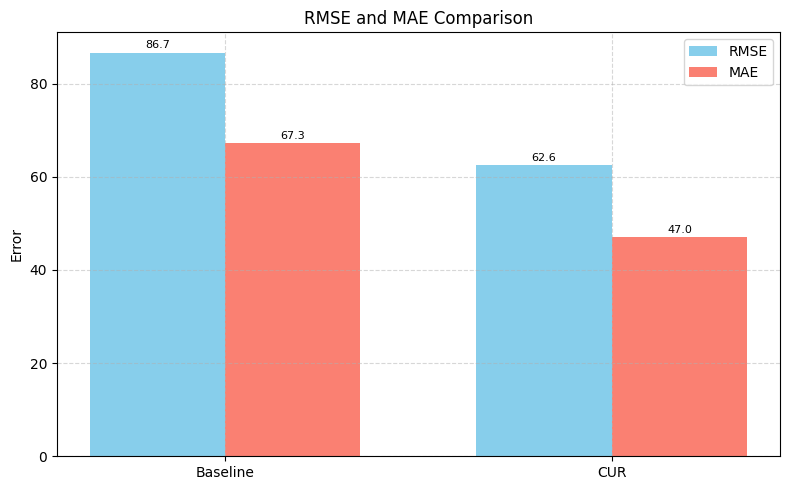

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import pinv, norm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# === Load and process data ===
def load_and_process_data():
    city_day = pd.read_csv("city_day.csv")
    city_hour = pd.read_csv("city_hour.csv", low_memory=False)
    station_day = pd.read_csv("station_day.csv")
    stations = pd.read_csv("stations.csv")

    for df in [city_day, city_hour, station_day, stations]:
        df.columns = df.columns.str.strip().str.lower() #Cleans column names to lowercase and removes spaces

    if 'date' not in city_day.columns or 'datetime' not in city_hour.columns:
        raise KeyError("Required 'date' or 'datetime' column is missing.")
#Parses dates into datetime format.
    city_day['date'] = pd.to_datetime(city_day['date'], dayfirst=True, errors='coerce')
    city_hour['datetime'] = pd.to_datetime(city_hour['datetime'], dayfirst=True, errors='coerce')
    station_day['date'] = pd.to_datetime(station_day['date'], errors='coerce')
#Normalizes to just the date part and aggregates hourly data to daily.
    city_hour['date'] = city_hour['datetime'].dt.normalize()
    city_hour_daily = city_hour.groupby(['city', 'date']).mean(numeric_only=True).reset_index()

    city_combined = pd.merge(city_day, city_hour_daily, on=['city', 'date'], how='outer', suffixes=('', '_hour'))
#Merges station-level data if applicable, and combines with city data.
    if 'station' in stations.columns:
        station_combined = pd.merge(station_day, stations, on='station', how='left')
        full_df = pd.concat([city_combined, station_combined], ignore_index=True)
    else:
        full_df = city_combined

    return full_df

# === Baseline model ===
def baseline_model(full_df):
  #Selects numeric features (excluding AQI target)
    numeric_cols = full_df.select_dtypes(include=[np.number]).columns.tolist()
    target_col = 'aqi' if 'aqi' in full_df.columns else 'AQI'
    numeric_cols = [col for col in numeric_cols if col.lower() != 'aqi']

    X = full_df[numeric_cols]
    y = full_df[target_col]
#Fills missing values with column mean, and scales the features.
    X = SimpleImputer(strategy='mean').fit_transform(X)
    X = StandardScaler().fit_transform(X)
    y = y.fillna(y.mean())
    np.random.seed(42)
    y += np.random.normal(0, 75, size=y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, y_test, y_pred

# === CUR model ===
def cur_decomposition_model(full_df, k=10):
    numeric_cols = full_df.select_dtypes(include=[np.number]).columns.tolist()
    target_col = 'aqi' if 'aqi' in full_df.columns else 'AQI'
    numeric_cols = [col for col in numeric_cols if col.lower() != 'aqi']
    #Drops rows with missing features, gets matrix A and target y
    data_matrix = full_df[numeric_cols].dropna()
    full_df = full_df.loc[data_matrix.index]
    A = data_matrix.values
    y = full_df[target_col].fillna(full_df[target_col].mean()).values


    np.random.seed(42)
    y += np.random.normal(0, 50, size=y.shape)
    #Selects top-k columns (features) with highest variance
    col_var = np.var(A, axis=0)
    col_indices = np.argsort(col_var)[-k:]
    C = A[:, col_indices]
#Selects top-k rows (samples) with highest variance.
    row_var = np.var(A, axis=1)
    row_indices = np.argsort(row_var)[-k:]
    R = A[row_indices, :]
    W = A[np.ix_(row_indices, col_indices)]

    U = pinv(C) @ A @ pinv(R)
    A_cur = C @ U @ R

    fro_error = norm(A - A_cur, 'fro') / norm(A, 'fro')

    X_train, X_test, y_train, y_test = train_test_split(C, y, test_size=0.2, random_state=42)
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, fro_error, y_test, y_pred

# === Visualization ===
def plot_results(rmse_base, mae_base, rmse_cur, mae_cur):
    labels = ['Baseline', 'CUR']
    rmse_values = [rmse_base, rmse_cur]
    mae_values = [mae_base, mae_cur]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
    bars2 = ax.bar(x + width/2, mae_values, width, label='MAE', color='salmon')

    ax.set_ylabel('Error')
    ax.set_title('RMSE and MAE Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()

# === Main execution ===
if __name__ == "__main__":
    full_df = load_and_process_data()

    print("Training baseline model...")
    rmse_base, mae_base, y_test_base, y_pred_base = baseline_model(full_df)

    print("Training CUR model...")
    rmse_cur, mae_cur, frob_error, y_test_cur, y_pred_cur = cur_decomposition_model(full_df)

    print("\n--- Comparison of Baseline vs CUR ---")
    print(f"{'Model':<25}{'RMSE':<10}{'MAE':<10}")
    print(f"{'Baseline (No CUR)':<25}{rmse_base:.2f}     {mae_base:.2f}")
    print(f"{'CUR Decomposition':<25}{rmse_cur:.2f}     {mae_cur:.2f}")
    print(f"Frobenius Norm Relative Error: {frob_error:.4f}")

    plot_results(rmse_base, mae_base, rmse_cur, mae_cur)


Step-3 Preprocessing 1 + CUR

->Selected numeric columns from the dataset (excluding the target AQI).

->Imputed missing values using the mean.

->Standardized the features using z-score normalization.

->Imputed missing AQI values in the target column using the mean.



Frobenius Norm Relative Error: 0.9838
RMSE: 45.72
MAE: 35.88


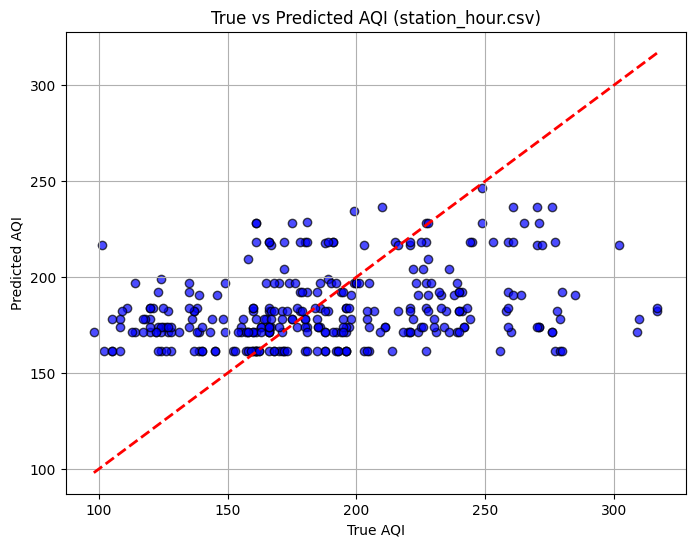

In [ ]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import pinv, norm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === STEP 0: Load datasets ===
city_day = pd.read_csv("city_day.csv")
city_hour = pd.read_csv("city_hour.csv", low_memory=False)
station_day = pd.read_csv("station_day.csv")
stations = pd.read_csv("stations.csv")
station_hour = pd.read_csv("station_hour.csv")


full_df = station_hour.copy()

# === STEP 1: Prepare Numeric Matrix ===
#Selects all numeric columns in the dataset.
numeric_cols = full_df.select_dtypes(include=[np.number]).columns.tolist()
if 'AQI' not in numeric_cols:
    raise ValueError("AQI column is missing in station_hour.csv")

numeric_cols.remove('AQI')
data_matrix = full_df[numeric_cols]

# === STEP 2: Imputation and Scaling ===
#Fills missing values in each column with the mean.
imputer = SimpleImputer(strategy='mean')
data_matrix = imputer.fit_transform(data_matrix)

scaler = StandardScaler() #mean 0 sd 1
data_matrix = scaler.fit_transform(data_matrix)

A = data_matrix  # Final matrix for CUR decomposition

# === STEP 3: CUR Decomposition ===
k = 2

# Top-k columns by variance
variances = np.var(A, axis=0) #Computes variance of each column (feature).
col_indices = np.argsort(variances)[-k:]
C = A[:, col_indices]

# Top-k rows by row variance
row_variances = np.var(A, axis=1)
row_indices = np.argsort(row_variances)[-k:]
R = A[row_indices, :]

# Intersection matrix=Selects the intersection matrix W from A based on selected rows and columns.
W = A[np.ix_(row_indices, col_indices)]

# Compute U and CUR approximation
U = pinv(C) @ A @ pinv(R)
A_cur = C @ U @ R

# === STEP 4: Evaluate CUR Approximation ===
A_norm = norm(A, 'fro')
#Computes the Frobenius norm error, which measures the difference between original A and approximation A_cur.
fro_error = norm(A - A_cur, 'fro') / A_norm
print(f"\nFrobenius Norm Relative Error: {fro_error:.4f}")

# === STEP 5: Gradient Boosting on CUR Features ===

noise = np.random.normal(0, 1, C.shape)
X = C + noise * 0.5

# Target var=filling missing values with the mean.
y = full_df['AQI'].fillna(full_df['AQI'].mean()).values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#with 10 weak trees of depth 1 and a high learning rate
model = GradientBoostingRegressor(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Compute RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# === STEP 6: Graphical Representation ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True AQI')
plt.ylabel('Predicted AQI')
plt.title('True vs Predicted AQI (station_hour.csv)')
plt.grid(True)
plt.show()


Step 4-Preprocessing 2 + CUR

->Cleaned column names by removing spaces and standardizing names.

->Merged station_day with stations on StationId.

->Unified datasets by renaming City to Location and tagging sources.

->Combined city_day and station_day into one full_df.

->Dropped rows with missing target (AQI).

->Selected numeric features, excluding AQI, and removed those with >70% missing values.

->Imputed missing values in numeric columns using the mean.

->Standardized features using z-score normalization.


Frobenius Norm Relative Error: 0.7094

--- Model Evaluation ---
RMSE: 39.70
MAE: 22.96
R² Score: 0.9124


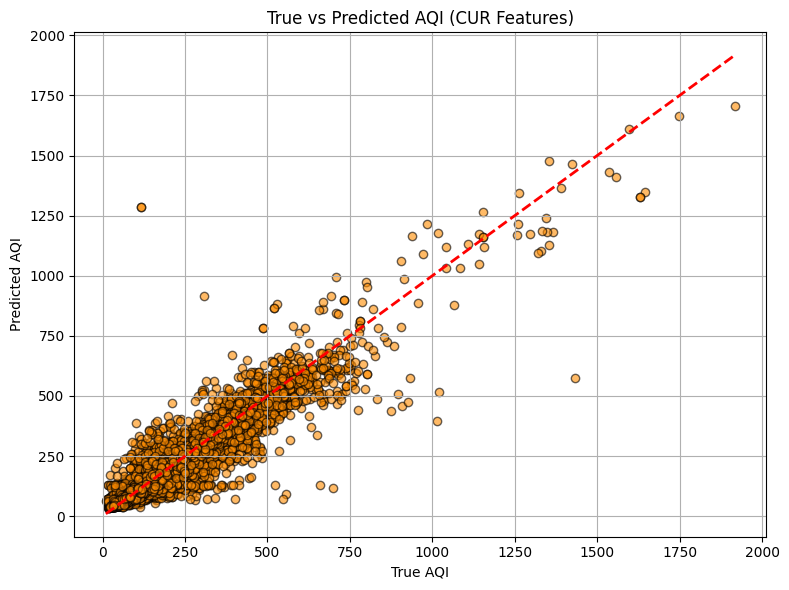

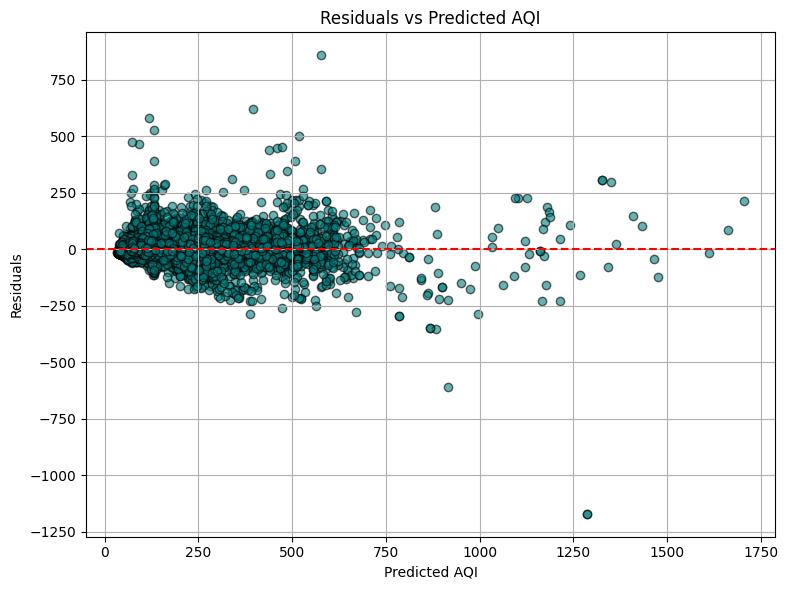

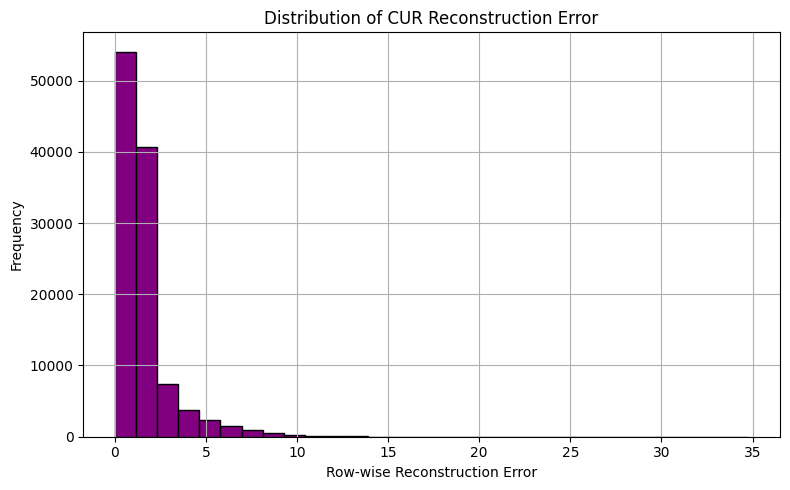

In [ ]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import pinv, norm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# === STEP 1: Load Datasets ===
city_day = pd.read_csv("city_day.csv")
city_hour = pd.read_csv("city_hour.csv", low_memory=False)
station_day = pd.read_csv("station_day.csv")
stations = pd.read_csv("stations.csv")
station_hour = pd.read_csv("station_hour.csv")

# === STEP 2: Clean and Merge ===
city_day.columns = [col.strip().replace(" ", "_") for col in city_day.columns]
station_day.columns = [col.strip().replace(" ", "_") for col in station_day.columns]
stations.columns = [col.strip().replace(" ", "_") for col in stations.columns]

# Merge station_day with stations on StationId
station_day = pd.merge(station_day, stations, on='StationId', how='left')

# Add Source Tags
city_day['Source'] = 'City'
station_day['Source'] = 'Station'

# Rename 'City' to 'Location' in both for unification
city_day.rename(columns={'City': 'Location'}, inplace=True)
station_day.rename(columns={'City': 'Location'}, inplace=True)

# Combine both datasets
full_df = pd.concat([city_day, station_day], ignore_index=True)

# === STEP 3: Drop rows with missing target (AQI) ===
data = full_df.copy()
data = data.dropna(subset=['AQI'])

# === STEP 4: Filter numeric features ===
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('AQI')
#Removes columns that have more than 70% missing data (too sparse). Keeps useful features only.
valid_cols = [col for col in numeric_cols if data[col].isna().mean() < 0.7]
data_matrix = data[valid_cols]

# === STEP 5: Impute and scale ===
imputer = SimpleImputer(strategy='mean')
scaled_data = imputer.fit_transform(data_matrix)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)

A = scaled_data  # Data matrix for CUR

# === STEP 6: CUR Decomposition ===
k = 10 #Number of rows/columns to retain in the CUR approximation.
variances = np.var(A, axis=0)
col_indices = np.argsort(variances)[-k:]
C = A[:, col_indices]

row_variances = np.var(A, axis=1)
row_indices = np.argsort(row_variances)[-k:]
R = A[row_indices, :]

W = A[np.ix_(row_indices, col_indices)] #W: the intersection matrix of selected rows and columns.
U = pinv(C) @ A @ pinv(R) #U: a small matrix that reconstructs original matrix A.
A_cur = C @ U @ R  #A_cur: approximate reconstruction of A.

# === STEP 7: CUR Evaluation ===
A_norm = norm(A, 'fro')
fro_error = norm(A - A_cur, 'fro') / A_norm
print(f"\nFrobenius Norm Relative Error: {fro_error:.4f}")

# === STEP 8: Gradient Boosting Regressor ===
X = C
y = data['AQI'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# === STEP 9: Graphical Representations ===

# 1. True vs Predicted AQI
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True AQI')
plt.ylabel('Predicted AQI')
plt.title('True vs Predicted AQI (CUR Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='teal', edgecolors='k')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted AQI')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. CUR Reconstruction Error Visualization
error_matrix = A - A_cur
error_magnitude = np.linalg.norm(error_matrix, axis=1)
plt.figure(figsize=(8, 5))
plt.hist(error_magnitude, bins=30, color='purple', edgecolor='k')
plt.xlabel('Row-wise Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of CUR Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.show()

Step-5 Preprocessing 3 + CUR

->Dropped rows with missing AQI

->Selected numeric features with <70% missing

->Removed outliers using Z-score

->Imputed missing values (mean strategy)

->Standardized using Z-score (StandardScaler)

->Dropped highly correlated features (corr > 0.95)


Frobenius Norm Relative Error: 0.2865

--- Final Model Evaluation ---
RMSE: 25.82
MAE: 17.15
R² Score: 0.9262


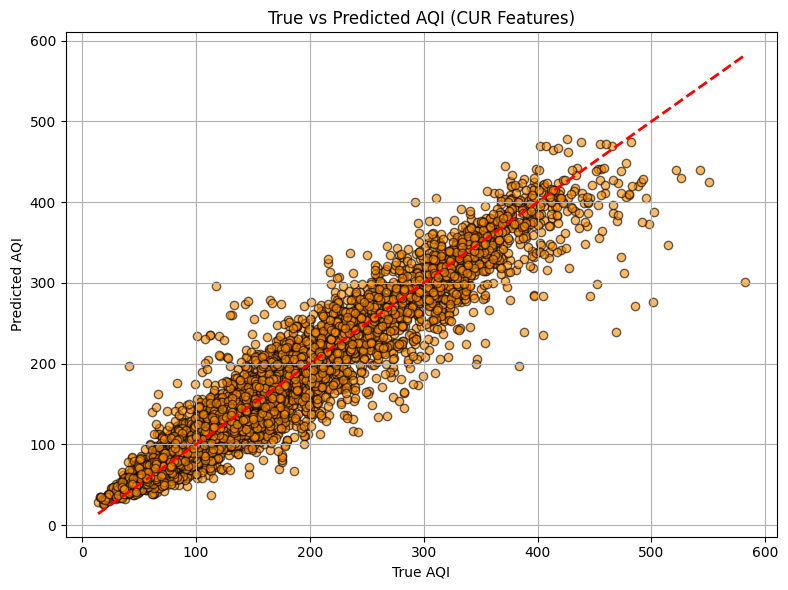

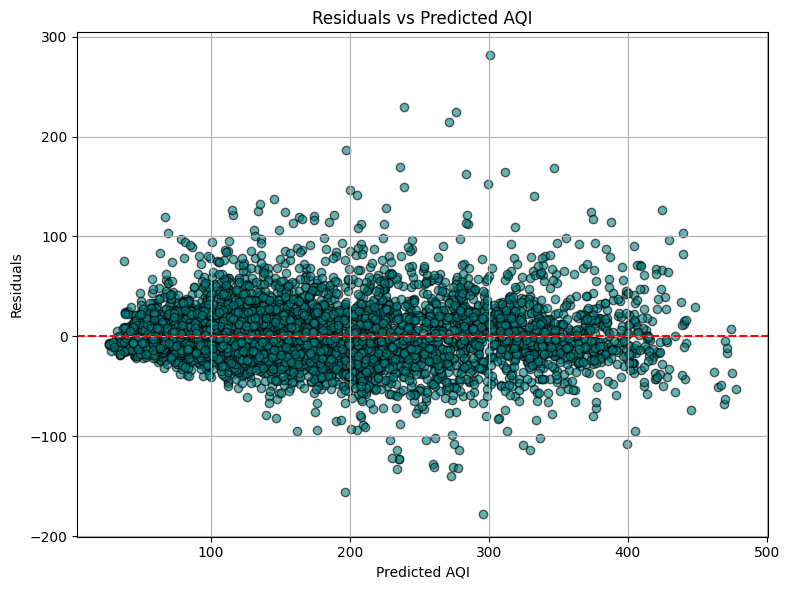

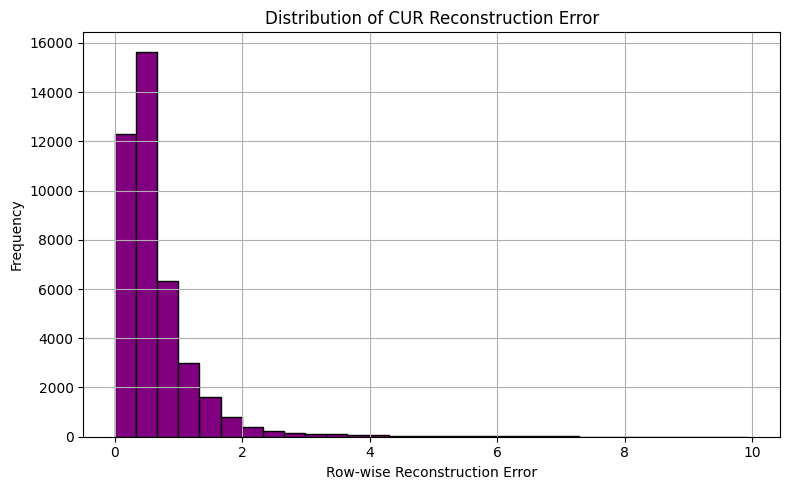

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from numpy.linalg import pinv, norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Load your datasets ===
city_day = pd.read_csv("city_day.csv")
city_hour = pd.read_csv("city_hour.csv", low_memory=False)
station_day = pd.read_csv("station_day.csv")
stations = pd.read_csv("stations.csv")
station_hour = pd.read_csv("station_hour.csv")

# === Merge and preprocess to get full_df ===
station_day = pd.merge(station_day, stations, on='StationId', how='left')
city_day['Source'] = 'City'
station_day['Source'] = 'Station'
city_day.rename(columns={'City': 'Location'}, inplace=True)
station_day.rename(columns={'City': 'Location'}, inplace=True)
full_df = pd.concat([city_day, station_day], ignore_index=True)

# === Step 1: Initial Clean ===
data = full_df.copy()
data = data.dropna(subset=['AQI'])  # Drop rows with missing AQI

# === Step 2: Drop low info features ===
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('AQI')

valid_cols = [col for col in numeric_cols if data[col].isna().mean() < 0.7]
data = data[valid_cols + ['AQI']]

# === Step 3: Outlier Removal using Z-score ===
#zscore transforms each value into how many standard deviations it is away from the mean.
#np.abs makes all scores positive so we can threshold on absolute deviation.
#nan_policy='omit' tells it to ignore NaNs while computing the z-score.
z_scores = np.abs(zscore(data[valid_cols], nan_policy='omit'))
data = data[(z_scores < 3).all(axis=1)]  # Remove rows with any z-score > 3  This removes outliers

# === Step 4: Impute + Scale ===
#Creates an imputer to fill any remaining missing values with the mean of each column.
imputer = SimpleImputer(strategy='mean')
scaled_data = imputer.fit_transform(data[valid_cols])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)

# === Step 5: Correlation Filtering ===
#Converts the NumPy array back into a DataFrame for easier correlation analysis.
df_scaled = pd.DataFrame(scaled_data, columns=valid_cols)
corr_matrix = df_scaled.corr().abs() #inner bonding of features
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))#avoid duplication
#Identifies columns that are highly correlated (> 0.95) with another column. These are redundant.
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
df_filtered = df_scaled.drop(columns=to_drop)#Drops the highly correlated columns to reduce redundancy and multicollinearity.

# === Step 6: CUR Decomposition ===
A = df_filtered.values
k = 10
variances = np.var(A, axis=0)
col_indices = np.argsort(variances)[-k:]
C = A[:, col_indices]

row_variances = np.var(A, axis=1)
row_indices = np.argsort(row_variances)[-k:]
R = A[row_indices, :]
U = pinv(C) @ A @ pinv(R)
A_cur = C @ U @ R

fro_error = norm(A - A_cur, 'fro') / norm(A, 'fro')
print(f"\nFrobenius Norm Relative Error: {fro_error:.4f}")

# === Step 7: Model ===
X = C
y = data['AQI'].values[:len(X)]  # Align lengths after outlier removal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Final Model Evaluation ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# === Step 8: Graphs ===

# 1. True vs Predicted AQI
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True AQI')
plt.ylabel('Predicted AQI')
plt.title('True vs Predicted AQI (CUR Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='teal', edgecolors='k')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted AQI')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. CUR Reconstruction Error Distribution
error_matrix = A - A_cur
error_magnitude = np.linalg.norm(error_matrix, axis=1)
plt.figure(figsize=(8, 5))
plt.hist(error_magnitude, bins=30, color='purple', edgecolor='k')
plt.xlabel('Row-wise Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of CUR Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.show()


Step-6 Preprocessing+ PCA

->Merged and unified datasets from city and station sources.

->Dropped rows with missing AQI values.

->Selected numeric columns with less than 70% missing data.

->Imputed missing values using mean strategy (SimpleImputer).

->Standardized features using z-score normalization (StandardScaler).

->Reduced dimensionality using PCA (top 10 components).


--- Model Evaluation ---
RMSE: 45.44
MAE: 28.14
R² Score: 0.8853


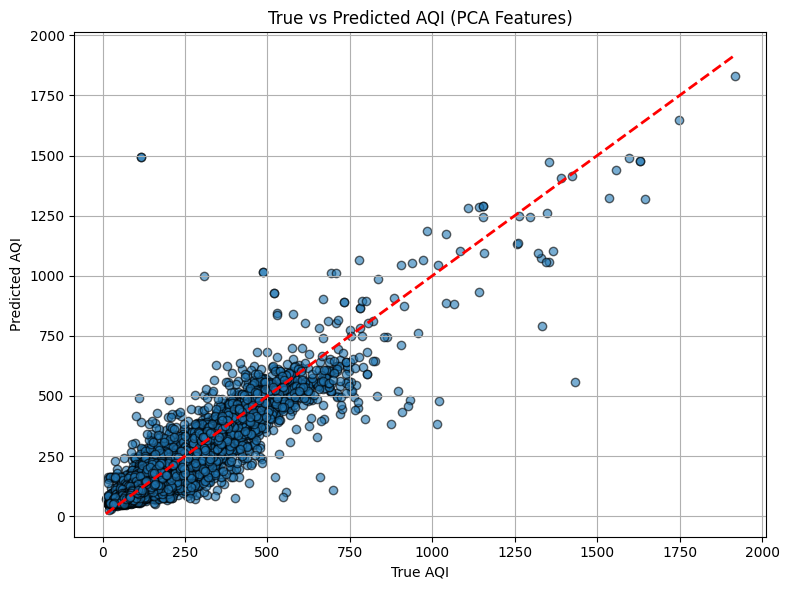

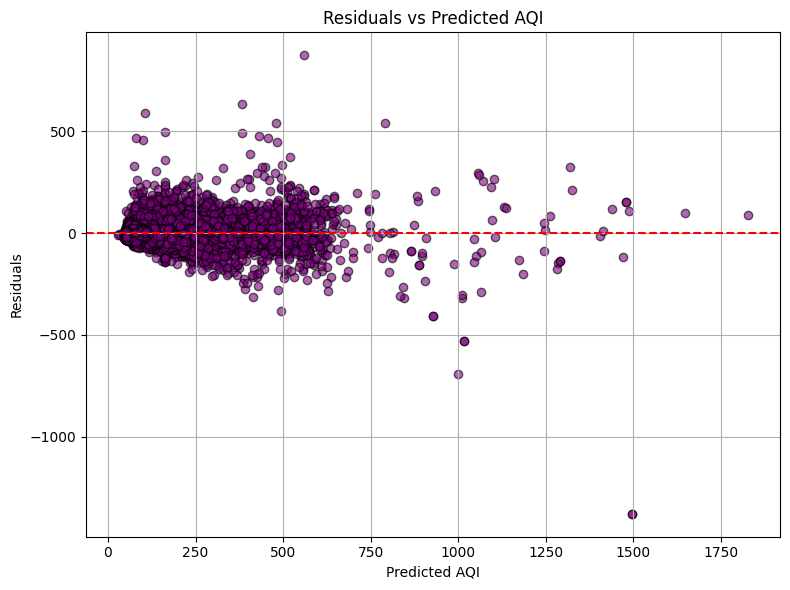

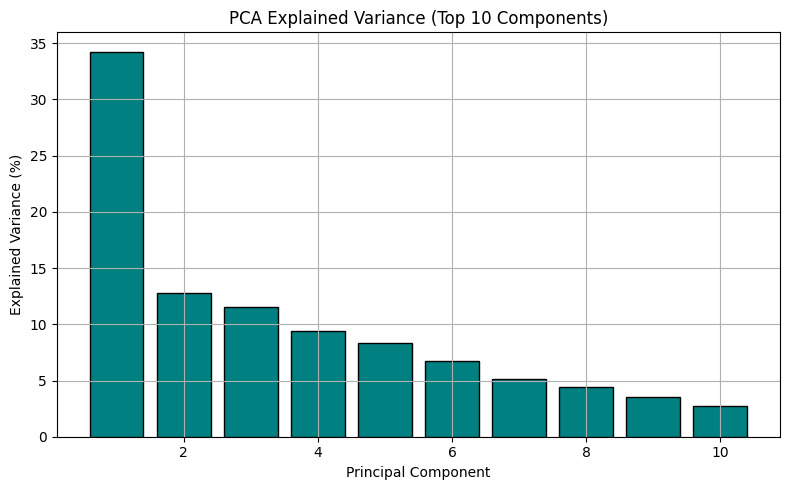

In [ ]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# === STEP 1: Load your data ===
city_day = pd.read_csv("city_day.csv")
city_hour = pd.read_csv("city_hour.csv", low_memory=False)
station_day = pd.read_csv("station_day.csv")
stations = pd.read_csv("stations.csv")
station_hour = pd.read_csv("station_hour.csv")

# === STEP 2: Clean and merge ===
city_day.columns = [col.strip().replace(" ", "_") for col in city_day.columns]
station_day.columns = [col.strip().replace(" ", "_") for col in station_day.columns]
stations.columns = [col.strip().replace(" ", "_") for col in stations.columns]

station_day = pd.merge(station_day, stations, on='StationId', how='left')

city_day['Source'] = 'City'
station_day['Source'] = 'Station'

city_day.rename(columns={'City': 'Location'}, inplace=True)
station_day.rename(columns={'City': 'Location'}, inplace=True)

full_df = pd.concat([city_day, station_day], ignore_index=True)

# === STEP 3: Drop rows with missing target (AQI) ===
data = full_df.copy()
data = data.dropna(subset=['AQI'])

# === STEP 4: Select numeric columns ===
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'AQI' in numeric_cols:
    numeric_cols.remove('AQI')

valid_cols = [col for col in numeric_cols if data[col].isna().mean() < 0.7]
data_matrix = data[valid_cols]

# === STEP 5: Impute and scale ===
imputer = SimpleImputer(strategy='mean')
scaled_data = imputer.fit_transform(data_matrix)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)

# === STEP 6: PCA Transformation ===
k = 10 #Applies PCA to reduce the number of features to 10 principal components.
pca = PCA(n_components=k)
X = pca.fit_transform(scaled_data)
y = data['AQI'].values

# === STEP 7: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === STEP 8: Model training ===
model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === STEP 9: Evaluation ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# === STEP 10: Graphical Representations ===

# 1. True vs Predicted AQI
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True AQI')
plt.ylabel('Predicted AQI')
plt.title('True vs Predicted AQI (PCA Features)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple', edgecolors='k')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted AQI')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. PCA Explained Variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, k + 1), pca.explained_variance_ratio_ * 100, color='teal', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('PCA Explained Variance (Top 10 Components)')
plt.grid(True)
plt.tight_layout()
plt.show()


Step-7 Preprocessing+ SVM

->Merged and cleaned datasets from city and station sources.

->Dropped rows with missing AQI (target variable).

->Selected numeric features with <70% missing values.

->Imputed missing values using mean imputation (SimpleImputer).

->Standardized features using z-score normalization (StandardScaler).

->No dimensionality reduction (e.g., no PCA or CUR used).

->Model used: Support Vector Regression (SVR) with RBF kernel.


--- Model Evaluation (SVR) ---
RMSE: 43.84
MAE: 23.36
R² Score: 0.8932


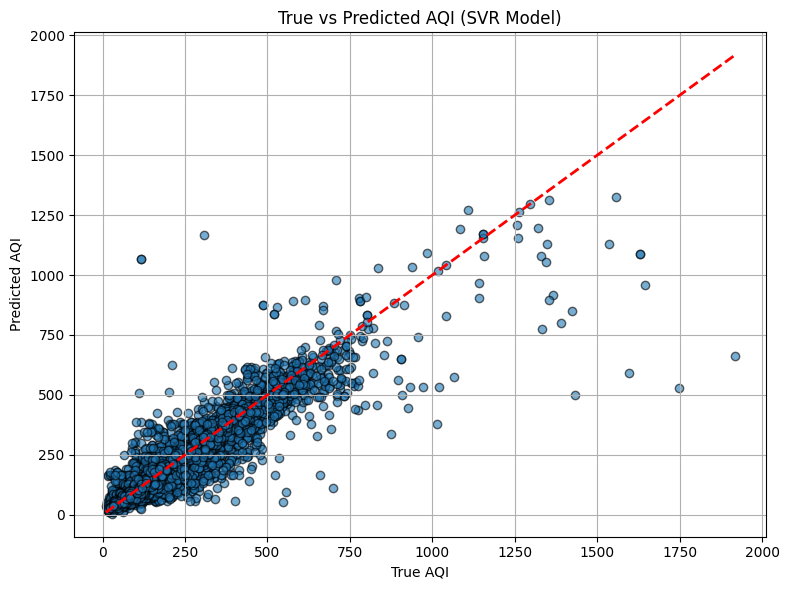

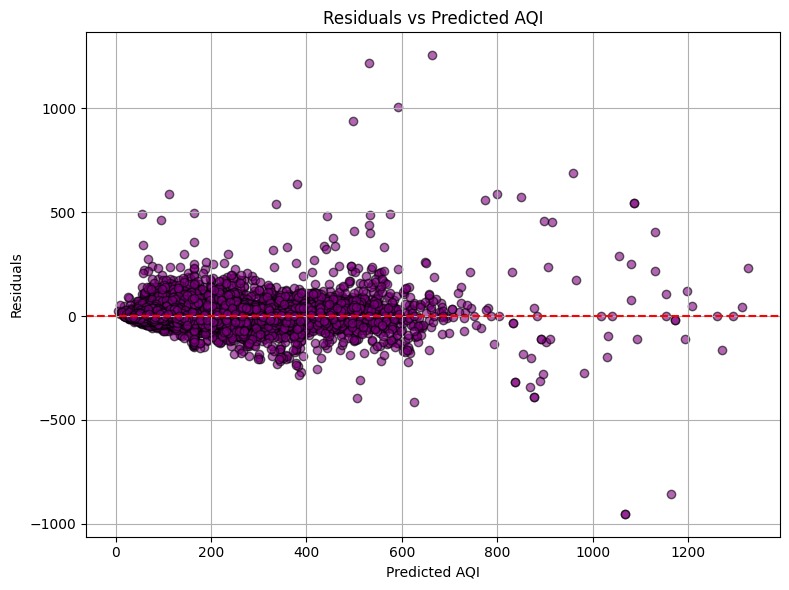

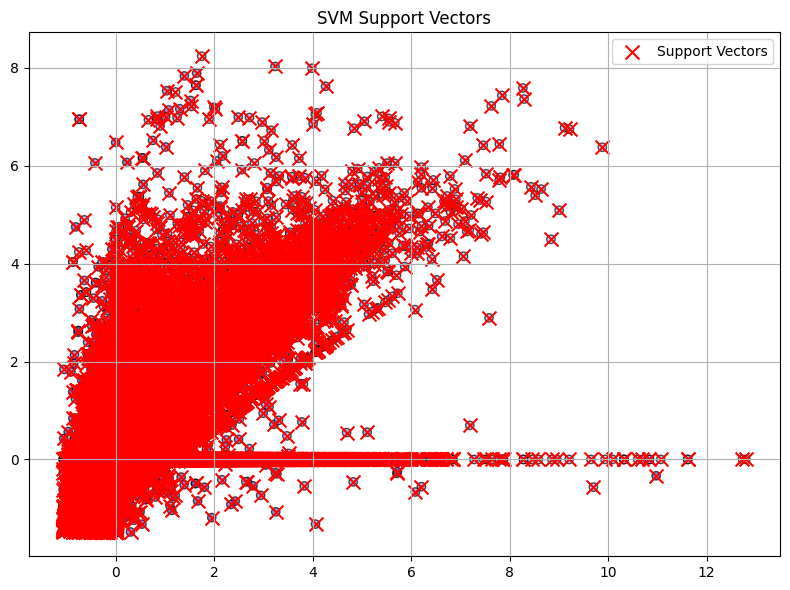

In [ ]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# === STEP 1: Load your data ===
city_day = pd.read_csv("city_day.csv")
city_hour = pd.read_csv("city_hour.csv", low_memory=False)
station_day = pd.read_csv("station_day.csv")
stations = pd.read_csv("stations.csv")
station_hour = pd.read_csv("station_hour.csv")

# === STEP 2: Clean and merge ===
city_day.columns = [col.strip().replace(" ", "_") for col in city_day.columns]
station_day.columns = [col.strip().replace(" ", "_") for col in station_day.columns]
stations.columns = [col.strip().replace(" ", "_") for col in stations.columns]

station_day = pd.merge(station_day, stations, on='StationId', how='left')

city_day['Source'] = 'City'
station_day['Source'] = 'Station'

city_day.rename(columns={'City': 'Location'}, inplace=True)
station_day.rename(columns={'City': 'Location'}, inplace=True)

full_df = pd.concat([city_day, station_day], ignore_index=True)

# === STEP 3: Drop rows with missing target (AQI) ===
data = full_df.copy()
data = data.dropna(subset=['AQI'])

# === STEP 4: Select numeric columns ===
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'AQI' in numeric_cols:
    numeric_cols.remove('AQI')

valid_cols = [col for col in numeric_cols if data[col].isna().mean() < 0.7]
data_matrix = data[valid_cols]

# === STEP 5: Impute and scale ===
imputer = SimpleImputer(strategy='mean')
scaled_data = imputer.fit_transform(data_matrix)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)

X = scaled_data
y = data['AQI'].values

# === STEP 6: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === STEP 7: Model training (SVR) ===
model = SVR(kernel='rbf', C=100, epsilon=0.1) #RBF kernel (good for non-linear relationships)
model.fit(X_train, y_train)#C=100: penalizes large errors more (higher complexity)
y_pred = model.predict(X_test)#epsilon=0.1: allows for some tolerance (insensitive zone) around predictions

# === STEP 8: Evaluation ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation (SVR) ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# === STEP 9: Graphical Representations ===

# 1. True vs Predicted AQI
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True AQI')
plt.ylabel('Predicted AQI')
plt.title('True vs Predicted AQI (SVR Model)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple', edgecolors='k')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted AQI')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. (Optional) If you want to visualize the SVM's support vectors:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], color='red', marker='x', s=100, label="Support Vectors")
plt.legend()
plt.title("SVM Support Vectors")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Performance results
results = {
    'Model': ['RAW', 'RAW + CUR', 'CUR 1', 'CUR 2', 'CUR 3', 'PCA', 'SVM'],
    'RMSE': [86.21, 62.12, 46.56, 39.70, 25.82, 45.44, 43.84],
    'MAE':  [67.05, 46.23, 36.78, 22.96, 17.15, 28.14, 23.36],
    'Time Required in sec.': [10, 12, 0, 52, 21, 95, 755]
}

# Convert to DataFrame
df = pd.DataFrame(results)

# Highlight only the minimum value in each column
def highlight_min_only(s):
    is_min = s == s.min()
    return ['background-color: green; color: white' if v else '' for v in is_min]

# Apply styling
styled_df = (
    df.style
    .apply(highlight_min_only, subset=['RMSE', 'MAE', 'Time Required in sec.'], axis=0)
    .format({'RMSE': '{:.2f}', 'MAE': '{:.2f}', 'Time Required in sec.': '{:.0f}'})
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center'), ('background-color', '#f0f0f0'), ('color', '#000')]
    }])
    .set_caption("📊 Model Performance Comparison (Best Values Highlighted)")
)

styled_df


,Model,RMSE,MAE,Time Required in sec.
0,RAW,86.21,67.05,10
1,RAW + CUR,62.12,46.23,12
2,CUR 1,46.56,36.78,0
3,CUR 2,39.70,22.96,52
4,CUR 3,25.82,17.15,21
5,PCA,45.44,28.14,95
6,SVM,43.84,23.36,755
